In [2]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras import backend as K
#from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle


import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

#To run project notebooks in subfolders as from root folder
import sys
sys.path.append('../../')

###Import self-written library
from featexlib import Debug as dbug
from featexlib import *

#for autorealoading the submodules
%load_ext autoreload
%autoreload 2

x_load.shape = (10, 256, 768, 3) , y_load.shape = (10, 256, 768, 7)
Amount of classes: 7


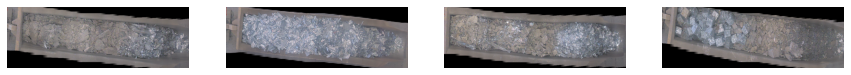

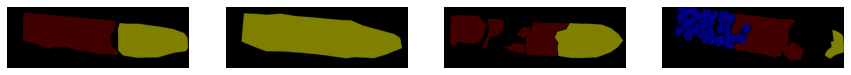

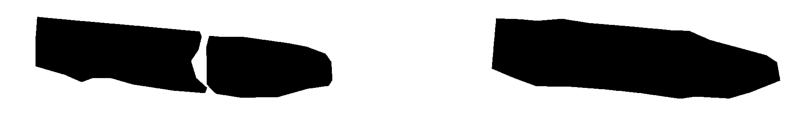

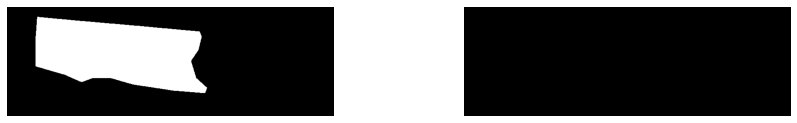

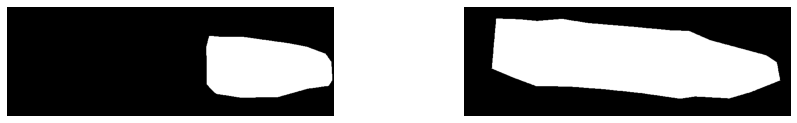

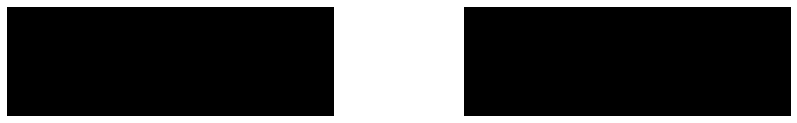

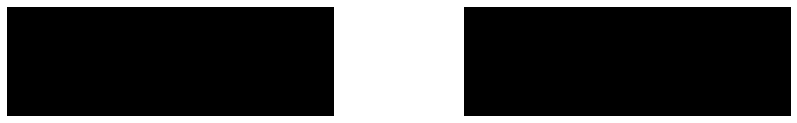

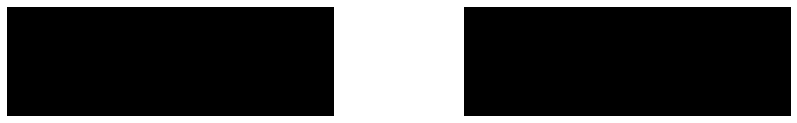

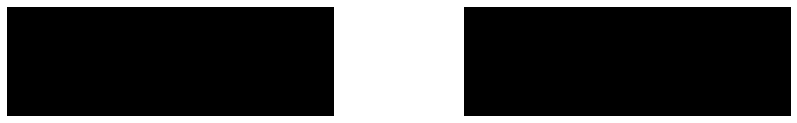

In [3]:
###ACTIVE CELL####
###Load data
###Testing that data has been saved and can be loaded

x_load, y_load, y_load_raw = Image_generator.load_data(save_dir = "../../Data/scrapid/training_data/", name="scrapid_7c_768x256_10_1")

print("===================================")

#Show some result images
print('x_load.shape =',x_load.shape,',', 'y_load.shape =',y_load.shape)
print('Amount of classes:',  y_load.shape[-1])
dbug.show_images_list(x_load[:4,...,[2,1,0]], col_number = 4)
dbug.show_images_list(y_load_raw[:4,...,[2,1,0]], col_number = 4)
for c in range(y_load.shape[-1]):
    dbug.show_images_list(y_load[:2,...,c], col_number = 2) 
    


In [4]:
###ACTIVE CELL####
###Split data to test and train
n_offset = 0
n_train = 8
n_test = 2
pic_h = x_load.shape[1]
pic_w = x_load.shape[2]
pic_ch = x_load.shape[3] if len(x_load.shape)>3 else 1
num_classes = y_load.shape[-1]

###Get X train and test
x_train, x_test = x_load[n_offset:n_offset+n_train], x_load[n_offset+n_train:n_offset+n_train+n_test]
y_train, y_test = y_load[n_offset:n_offset+n_train], y_load[n_offset+n_train:n_offset+n_train+n_test]
y_train_raw, y_test_raw = y_load_raw[n_offset:n_offset+n_train], y_load_raw[n_offset+n_train:n_offset+n_train+n_test]

print("===============Data is ready====================")
print("Shape X,Y for train:",x_train.shape,y_train.shape)
print("Shape X,Y for test: ",x_test.shape,y_test.shape)

###Clean memory
del x_load, y_load, y_load_raw

===============Data is ready====================
Shape X,Y for train: (8, 256, 768, 3) (8, 256, 768, 7)
Shape X,Y for test:  (2, 256, 768, 3) (2, 256, 768, 7)


In [5]:
###ACTIVE CELL####
###Reshape and then rescale dataset
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1))
x_test_sc  = scaler.transform(x_test.reshape(x_test.shape[0],-1))

if y_train.max() > 1:
    y_train_sc = y_train/255
    y_test_sc  = y_test/255
else:
    y_train_sc = y_train
    y_test_sc  = y_test
        
print(x_train_sc.shape, y_train_sc.shape, x_test_sc.shape, y_test_sc.shape)

(8, 589824) (8, 256, 768, 7) (2, 589824) (2, 256, 768, 7)


In [6]:
###ACTIVE CELL####
x_test_sc.mean()

0.6479255218017026

In [24]:
###ACTIVE CELL#####
###Calculate dataset balancing

balance_table = np.array([np.mean(np.argmax(y_train, axis=-1) == c) for c in range(y_train.shape[-1])])
print('Class balance:')
print(balance_table)

def get_balanced_weight(inp, norm=False):
    norm_inp =  inp/inp.sum()
    
    num_classes = len(inp)
    
    ideal = 1/num_classes
    
    k_arr = np.array([(ideal/i) if i != 0 else 0 for i in norm_inp] )
    
    if norm:
        return k_arr/k_arr.sum()
    else:
        return k_arr

################################
###Enter custom balance table if you want:
#e.g. 
balance_table = np.array([0.2, 0.2, 0.2 , 0.1, 0.05, 0.05, 0.1])

class_weights = get_balanced_weight(balance_table)
print('Weight table:')
print(class_weights)


Class balance:
[0.59298325 0.12553024 0.2270902  0.04632505 0.00661596 0.00145531
 0.        ]
Weight table:
[0.64285714 0.64285714 0.64285714 1.28571429 2.57142857 2.57142857
 1.28571429]


In [6]:
###ACTIVE CELL####
###Export scaler
pickle.dump(scaler, open('../../models/scalers/scrapid_7c_850x256_10_1_unet_scaler_v1.pkl','wb'))

###Load scaler
#scaler = pickle.load(open('models/scalers/scrapid_7c_850x256_10_1_unet_scaler_v1.pkl','rb'))

In [ ]:
###Load scaler
##NOT USED
scaler = pickle.load(open('models/scalers/scrapid_7c_850x256_10_1_unet_scaler_v1.pkl','rb'))
x_test_sc  = scaler.transform(x_test.reshape(x_test.shape[0],-1))
x_test_sc.mean()

In [8]:
###ACTIVE CELL####
###Prepare for training: check labels dimension (-1), change X to float32 instead of float64
ys = y_train_sc.astype('float32').reshape(-1,pic_h,pic_w,num_classes)
xs = x_train_sc.astype('float32').reshape(-1,pic_h,pic_w,pic_ch)
#ys_one_hot = tf.one_hot(ys, num_classes) ###not used

ys_test = y_test_sc.reshape(-1,pic_h,pic_w,num_classes)
xs_test = x_test_sc.astype('float32').reshape(-1,pic_h,pic_w,pic_ch)

###Clear memory
#del x_train, y_train, y_test, x_test
print(xs.shape, ys.shape, xs_test.shape, ys_test.shape)

(8, 256, 768, 3) (8, 256, 768, 7) (2, 256, 768, 3) (2, 256, 768, 7)


In [28]:
###ACTIVE CELL####
#Model
#Prepare model transfer-learned VGG16

K.clear_session()
def unet(pretrained_weights = None,input_size = (256,768,3), full_train=False):
    VGG16_weight = "../../models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    VGG16 = tf.keras.applications.VGG16(include_top=False, weights=VGG16_weight, input_shape=input_size)
    last_layer = VGG16.output
    for layer in VGG16.layers:
        if layer.name in ['block1_conv1']:
            set_trainable = True
        if layer.name in ['block1_pool','block2_pool','block3_pool','block4_pool','block5_pool']:
            layer.trainable = full_train
            
    model_ = tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2, 2), padding='same')(last_layer)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)    
    
    concat_1 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block5_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1), padding='same')(concat_1)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(512,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_2 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block4_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(512,(3,3),strides=(1, 1), padding='same')(concat_2)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(512,(3,3),strides=(2, 2), padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_3 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block3_conv3").output])
    
    model_ = tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1), padding='same')(concat_3)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(256,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_4 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block2_conv2").output])
    
    model_ = tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1), padding='same')(concat_4)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2DTranspose(128,(3,3),strides=(2, 2),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_) 
    
    concat_5 = tf.keras.layers.concatenate([model_,VGG16.get_layer("block1_conv2").output])
    
    model_ = tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1), padding='same')(concat_5)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1), padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    
    model_ = tf.keras.layers.Conv2D(7,(3,3),strides=(1, 1),padding='same')(model_)
    model_ = tf.keras.layers.LeakyReLU(0.1)(model_)
    model_ = tf.keras.layers.BatchNormalization()(model_)
    #model_ = tf.keras.layers.Softmax()(model_)

    model_ = tf.keras.Model(VGG16.input,model_)
    
    model_.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4), loss=weightedLoss(tf.keras.losses.CategoricalHinge(), class_weights), metrics=[Mean_IOU_tensorflow_2])
    #model_.compile(optimizer='sgd', loss=weightedLoss(tf.keras.losses.MeanSquaredError(), class_weights), metrics=[Mean_IOU_tensorflow_2])
    #model_.compile(optimizer='sgd', loss=tf.keras.losses.MeanSquaredError(), metrics=[Mean_IOU_tensorflow_2])
    
    #model_.compile(optimizer ='sgd', loss = 'categorical_hinge', metrics = [Mean_IOU_tensorflow_2])
    #model_.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'categorical_hinge', metrics = ['accuracy'])
    #model_.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    if(pretrained_weights):
        model_.load_weights(pretrained_weights)
    
    return model_

def Mean_IOU_tensorflow_2(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    iou = []
    true_pixels = K.argmax(y_true, axis=-1)
    pred_pixels = K.argmax(y_pred, axis=-1)
    void_labels = K.equal(K.sum(y_true, axis=-1), 0)
    for i in range(0, nb_classes): # exclude first label (background) and last label (void)
        true_labels = K.equal(true_pixels, i) & ~void_labels
        pred_labels = K.equal(pred_pixels, i) & ~void_labels
        inter = tf.cast(true_labels & pred_labels, tf.int32)
        union = tf.cast(true_labels | pred_labels, tf.int32)
        legal_batches = K.sum(tf.cast(true_labels, tf.int32), axis=1)>0
        ious = K.sum(inter, axis=1)/K.sum(union, axis=1)
        iou.append(K.mean(ious[legal_batches]))
    iou = tf.stack(iou)
    legal_labels = ~tf.math.is_nan(iou)
    iou = iou[legal_labels]
    return K.mean(iou)


def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first

        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.cast(K.argmax(true, axis=axis), tf.int32) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [29]:
model = unet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 768, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 768, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [30]:
model.fit(xs, ys, batch_size=1, epochs=60, steps_per_epoch = 8, shuffle=True)

Epoch 1/60
8/8 [==============================] - 54s 6s/step - loss: 1.4399 - Mean_IOU_tensorflow_2: 0.2056
Epoch 2/60
8/8 [==============================] - 53s 7s/step - loss: 1.1167 - Mean_IOU_tensorflow_2: 0.2994
Epoch 3/60
8/8 [==============================] - 53s 7s/step - loss: 0.9055 - Mean_IOU_tensorflow_2: 0.3573
Epoch 4/60
8/8 [==============================] - 53s 7s/step - loss: 0.7558 - Mean_IOU_tensorflow_2: 0.4125
Epoch 5/60
8/8 [==============================] - 53s 7s/step - loss: 0.6441 - Mean_IOU_tensorflow_2: 0.4560
Epoch 6/60
8/8 [==============================] - 57s 7s/step - loss: 0.5716 - Mean_IOU_tensorflow_2: 0.4873
Epoch 7/60
8/8 [==============================] - 55s 7s/step - loss: 0.5351 - Mean_IOU_tensorflow_2: 0.4991
Epoch 8/60
8/8 [==============================] - 54s 7s/step - loss: 0.5174 - Mean_IOU_tensorflow_2: 0.5031
Epoch 9/60
8/8 [==============================] - 53s 7s/step - loss: 0.4807 - Mean_IOU_tensorflow_2: 0.5236
Epoch 10/60
8/8 [==

In [17]:
#fit model for big data

checkpointer = tf.keras.callbacks.ModelCheckpoint('../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5', verbose=1,mode='auto', monitor='loss',save_best_only=True)

def GenerateInputs(X,y):
    for i in range(len(X)):
        X_input = X[i].reshape(-1,pic_h,pic_w,pic_ch)
        y_input = y[i].reshape(-1,pic_h,pic_w,num_classes)
        yield (X_input,y_input)
        
model.fit_generator(GenerateInputs(xs,ys), epochs=10, verbose=1,callbacks=[checkpointer],
                     steps_per_epoch=8,shuffle=True)

<ipython-input-17-f83511d67a2f>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(GenerateInputs(xs,ys), epochs=10, verbose=1,callbacks=[checkpointer],


Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 0.7589 - Mean_IOU_tensorflow_2: 0.6284
Epoch 00001: loss improved from inf to 0.75894, saving model to ../../models/scrapid_7c_850x256_10_1_unet_vgg16.h5
1/1 [==============================] - 9s 9s/step - loss: 0.7589 - Mean_IOU_tensorflow_2: 0.6284
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 0.9074 - Mean_IOU_tensorflow_2: 0.6292
Epoch 00002: loss did not improve from 0.75894
1/1 [==============================] - 6s 6s/step - loss: 0.9074 - Mean_IOU_tensorflow_2: 0.6292
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 0.8616 - Mean_IOU_tensorflow_2: 0.6062
Epoch 00003: loss did not improve from 0.75894
1/1 [==============================] - 7s 7s/step - loss: 0.8616 - Mean_IOU_tensorflow_2: 0.6062
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 1.1621 - Mean_IOU_tensorflow_2: 0.3893
Epoch 00004: loss did not improve from 0.75894
1/1 [============================

In [34]:
###Save model 1 after training
model.save_weights('../../models/scrapid_7c_850x256_10_1_unet_acc09391')

In [73]:
###Continue model training
model = unet()
model.load_weights('../../models/scrapid_7c_850x256_10_1_unet_acc09391')
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 768, 64  1792        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 768, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

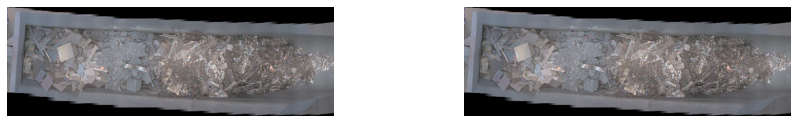

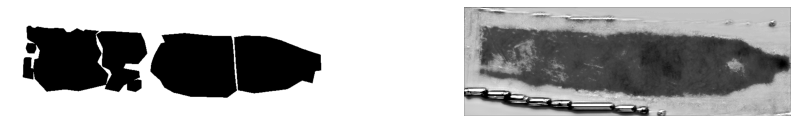

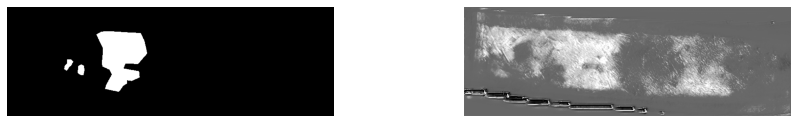

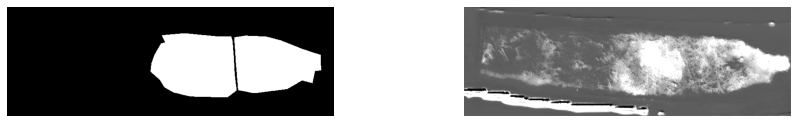

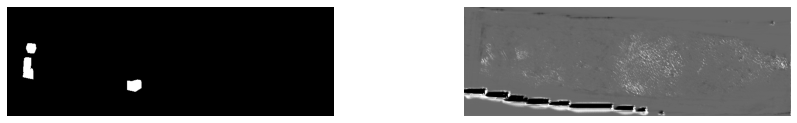

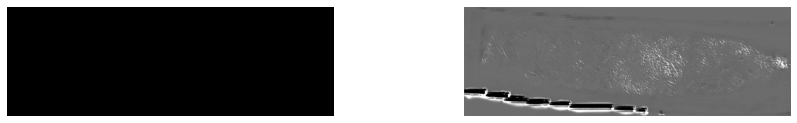

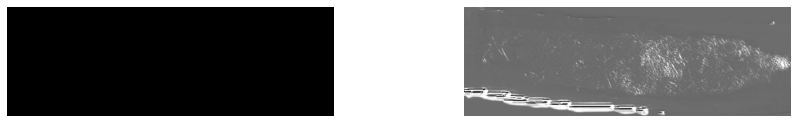

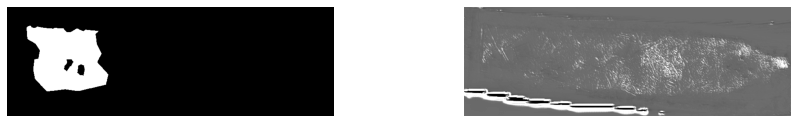

In [25]:
def show_predict(x,x_orig,y_orig, number):
    y_pred = model(x[number].reshape(-1,pic_h,pic_w,pic_ch)).numpy()
    y_pred = (np.clip(((y_pred - y_pred.mean() + y_pred.std())/y_pred.std())*127, 0,255)).astype('int16')
    dbug.show_images_list([x_orig[number],x_orig[number]], col_number = 2)
    for c in range(y_orig.shape[-1]):
        dbug.show_images_list([y_orig[number,...,c].reshape(pic_h,pic_w,1), y_pred[...,c].reshape(pic_h,pic_w,1)], col_number = 2) 


numm = 1
show_predict(xs_test,x_test,y_test, numm)

In [31]:
####ACTIVE CELL#####
#Helpful functions for showing result

#List of codes, should be the same as in training
list_of_codes = [
    0, #Black
    64, #Dark red
    32896, #Yellow
    8388608, #Blue
    32768, #Green
    192, #Red
    8388736, #Violet
]

#Help function to get RGB codes from DEC
def get_rgb_from_codes(inp):
    return np.array([[i//65536,(i - 65536*(i//65536))//256, i - 65536*(i//65536) - 256*((i - 65536*(i//65536))//256)] for i in inp]).astype(np.uint8)

list_of_colors = get_rgb_from_codes(list_of_codes)


def show_predict_multi(x,x_orig,y_orig, number):
    
    y_pred = model(x[number].reshape(-1,pic_h,pic_w,pic_ch)).numpy()
    
    res_r = np.argmax(y_pred, axis=3)
    res_g = np.copy(res_r)
    res_b = np.copy(res_r)



    for c in range(y_pred.shape[-1]):
        res_r[res_r == c] =  list_of_colors[c,0]
        res_g[res_g == c] =  list_of_colors[c,1]
        res_b[res_b == c] =  list_of_colors[c,2]

    res = np.concatenate([res_r[...,None],res_g[...,None],res_b[...,None]], axis=3)
    
    
    for c in range(res.shape[0]):
        dbug.show_images_list([x_orig[number][c,...][...,[2,1,0]],res[c,...][...,[2,1,0]],y_orig[number][c,...][...,[2,1,0]]],col_number = 3)
        #dbug.show_images_list(res[c,...],col_number = 3)
        #dbug.show_images_list(y_orig[number][c,...],col_number = 3)

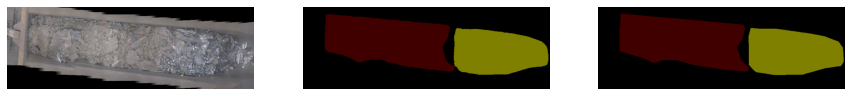

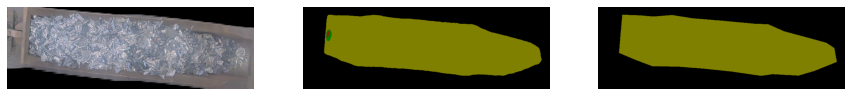

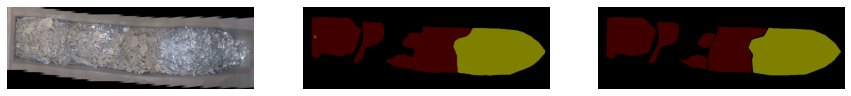

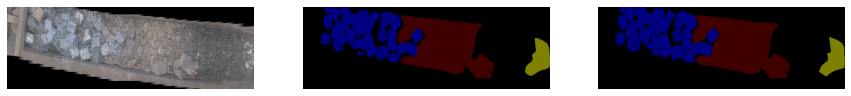

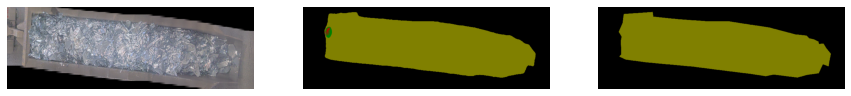

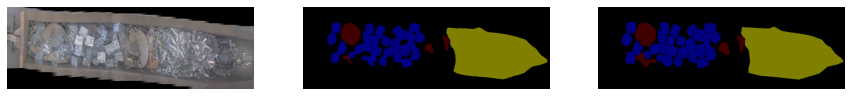

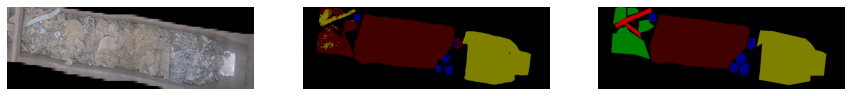

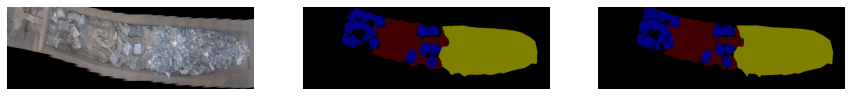

In [32]:
####ACTIVE CELL###########
####Show result in train dataset

num = [0,1,2,3,4,5,6,7]
show_predict_multi(xs,x_train,y_train_raw,num)        

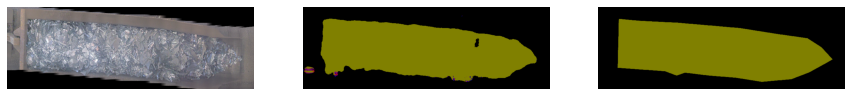

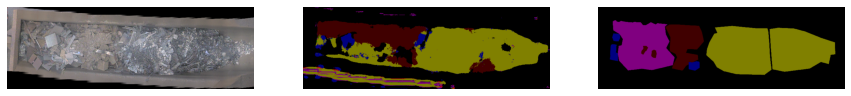

In [33]:
####ACTIVE CELL###########
####Show result in test dataset

num = [0,1]
show_predict_multi(xs_test,x_test,y_test_raw,num)   